# Estimate distribution params

This notebook illustrates how the parameters of distributions can be estimated using `dist_cov`.

In [1]:
import corner
import matplotlib.pyplot as plt
import numpy as np

import dist_cov

## Create random data

From a normal distribution with a slope of 0.5:

In [2]:
t = np.arange(0, 10, 0.1)

rng = np.random.default_rng()

x = rng.normal(size=t.size) + t * 0.5

## Plot the sample data

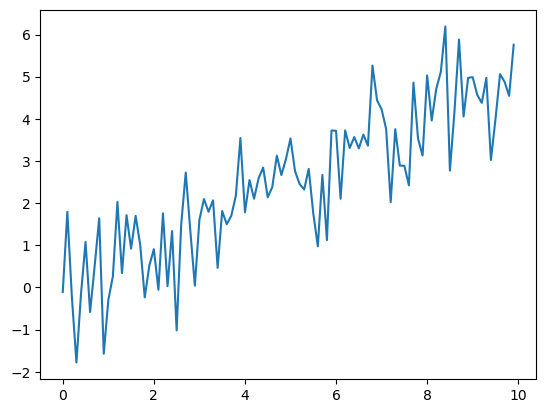

In [3]:
f, ax = plt.subplots()

ax.plot(t, x)

## Fitting the distribution

We use `dist_cov.distributions.norm_cov` which is a normal distribution with a non-constant location ($\mu$) and standard deviation ($\sigma$):

$\mu' = \beta_0 + \beta_1 * cov$

$\sigma' = \sigma$

We first need to initialize the distribution by passing the data and the covariate:

In [4]:
dist = dist_cov.distributions.norm_cov(data=x, cov=t)

From this we can fit the three params using the maximum likelihood estimation (mle):

In [5]:
params_mle = dist.fit()

print(dist.param_names)
print(np.round(params_mle, 3))

['b0', 'b1', 'sigma']
[-0.087  0.519  0.887]


## 'Predict' the mean (location)

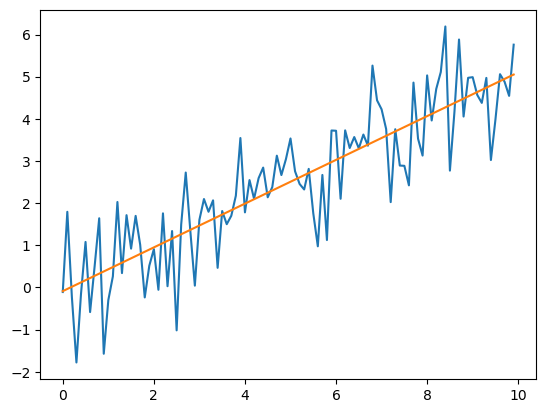

In [6]:
predicted = dist.predict(params_mle, t)

# ===

f, ax = plt.subplots()

ax.plot(t, x)

ax.plot(t, predicted)

## Estimating the parameter uncertainty

We use a Affine Invariant Markov chain Monte Carlo (MCMC) Ensemble sampler ([emcee](https://emcee.readthedocs.io/en/stable/)) to create samples of the params. Note: more samples are generally desirable.

In [7]:
sampler = dist_cov.sample.run_mcmc(dist, burn_in=125, production=500)

Running burn-in...
Running production...


The samples are stored in `sampler.flatchain`:

In [8]:
sampler.flatchain

array([[-0.03244353,  0.48898273,  1.0216251 ],
       [-0.20708536,  0.54035397,  0.92152374],
       [-0.22823246,  0.53473044,  0.93360245],
       ...,
       [ 0.1322758 ,  0.46138849,  0.83925694],
       [ 0.05621165,  0.48625191,  0.87563651],
       [-0.15637454,  0.56138755,  1.05773001]])

And the resulting log-likelihood surface can be visualized with the [corner](https://corner.readthedocs.io/en/latest/) package:

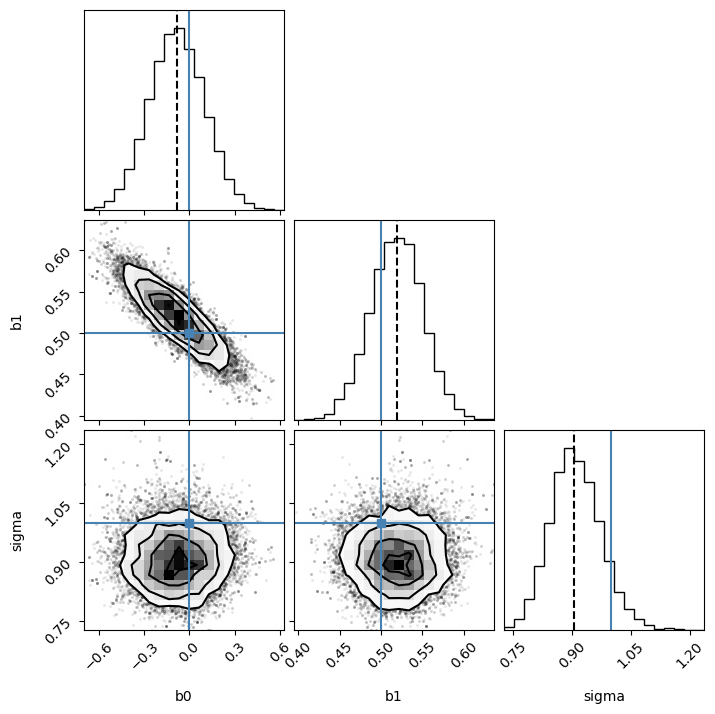

In [9]:
corner.corner(sampler.flatchain, labels=dist.param_names, truths=[0, 0.5, 1], quantiles=[0.5]);

From this the best estimate of the params is usually derived from their median:

In [10]:
params_best_estimate = np.median(sampler.flatchain, axis=0)

params_best_estimate

array([-0.08312637,  0.51933269,  0.90650982])

And their likely range as quantiles - here displaying the 50, 2.5 and 97.5 percentile:

In [11]:
for i, name in enumerate(dist.param_names):
    param_range = dist_cov.utils.fmt_param_range(sampler.flatchain[:, i], alpha=0.05)
    print(f"{name:5s}: {param_range}")

b0   : -0.083 (-0.439 to  0.279)
b1   :  0.519 ( 0.456 to  0.581)
sigma:  0.907 ( 0.793 to  1.046)


## Show uncertainty of location

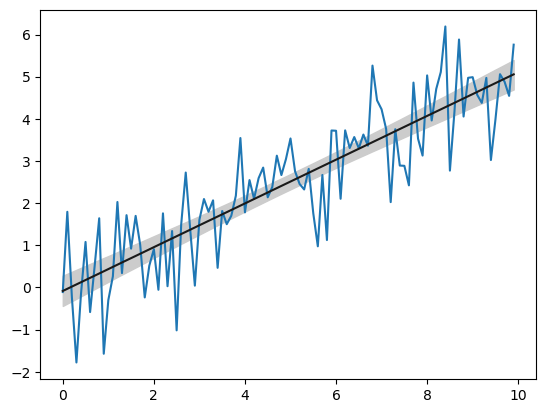

In [12]:
predicted_mcmc = dist.predict(sampler.flatchain, np.atleast_2d(t).T)

p_be, p_lb, p_ub = np.quantile(predicted_mcmc, q=[0.5, 0.025, 0.975], axis=1)

# ===

f, ax = plt.subplots()

ax.plot(t, x)

ax.plot(t, p_be, color="0.1")

ax.fill_between(t, p_lb, p_ub, color="0.8")

## Estimate cumulative distribution etc.

The distributions also offer a cumulative distribution function `cdf`, percent point function (`ppf`), survival function (`sf`), and inverse survival function (`isf`). E.g., to estimate the probability that the distribution is below -0.5, given a covariate of 1:

In [13]:
p_below = dist.cdf(-0.5, params_mle, cov=1)
p_below

0.1467828706175277

Again, the uncertainty of the cdf can be estimated by passing the samples:

In [14]:
p_below_mcmc = dist.cdf(-0.5, sampler.flatchain, cov=1)

p_below_mcmc

array([0.17456148, 0.18293696, 0.19383353, ..., 0.0962645 , 0.11692086,
       0.19610451])

Plot the estimates, the best estimate and uncertainty:

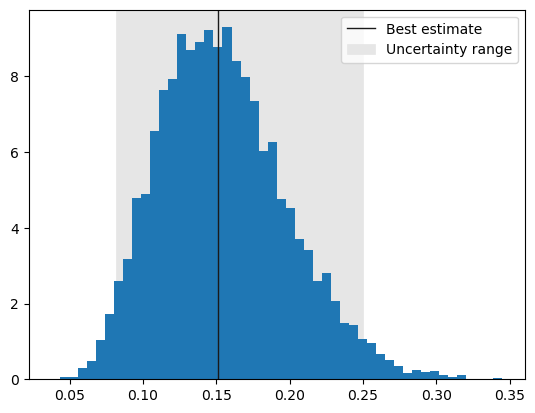

In [15]:
alpha = 0.05

be, lb, ub = dist_cov.utils.param_range(p_below_mcmc, alpha=alpha)

# ===

f, ax = plt.subplots()

ax.hist(p_below_mcmc, bins=50, density=True, stacked=True)

ax.axvline(be, color="0.1", lw=1, label="Best estimate")
ax.axvspan(lb, ub, color="0.9", lw=0.5, zorder=0.1, label="Uncertainty range")

ax.legend()

## Remarks

Using a normal distribution with a variable location parameter is equivalent to a linear regression. Note that the params are ordered differently:

In [16]:
params_polyfit = np.polyfit(t, x, deg=1)
params_fit = dist.fit()

slope_p, interc_p = params_polyfit

interc_f, slope_f, std_f = params_fit

print("Intercept and slope:")
print(f"- poylfit : {interc_p:0.3f}, {slope_p:0.3f}")
print(f"- norm_cov: {interc_f:0.3f}, {slope_f:0.3f}")

Intercept and slope:
- poylfit : -0.087, 0.519
- norm_cov: -0.087, 0.519


The third parameter is not directly given by the linear regression but is the standard deviation of the residuals:

In [17]:
residuals = x - np.polyval(params_polyfit, t)
std_p = np.std(residuals)

print("Standard deviation:")
print(f"- poylfit : {std_p:0.3f}")
print(f"- norm_cov: {std_f:0.3f}")

Standard deviation:
- poylfit : 0.887
- norm_cov: 0.887
